<a href="https://colab.research.google.com/github/RRahul-Abrol/Starting-with-Agentic-Ai/blob/main/smart%20agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [6]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.5-flash", api_key=GOOGLE_API_KEY)
llm_with_tools = llm.bind_tools(tools)

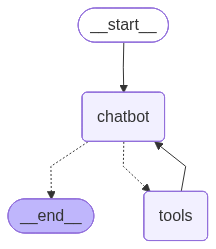

In [36]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools","chatbot")

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
state = graph.invoke({"messages": [{"role": "user", "content": "i want to buy 50 aapl stocks at current price so how much amount should i have to buy them?"}]})
print(state["messages"][-1].content)

[{'type': 'text', 'text': 'You should have 5020.0 to buy 50 AAPL stocks.', 'extras': {'signature': 'Cu8BAXLI2nyA7QANfa/1myp81TEiK3r8TvKoT9BbosdXJWDZlbxit/3e85rlywZmAU+wIPl8D9nNpdOFHM9B+X1facvLAvpHDZUqJTvz0YESB+h/xQtOH6hvrpOCN1gKU20mZ/QUpbf/bvgrj94z/Ou6gXtM0aSGlQorjqeAsuX3+VoiqiVz//1TmulQ3oxqVLvWRkJXp67DKOpOWwX/rPwLx05jOluaJfHgZEsTokmdoWBRUzuE8bQbTeCFcqivJqLCYHmE9PjgyrxwRUOO+0rlJNfRtqRy3ce3aKmPMQ+QE5SRxwuydwsRzVwofBBAXXU='}}]
